In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

from tqdm import tqdm
import umap
from matplotlib import pyplot as plt
import xgboost as xgb

from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from imblearn.over_sampling import SMOTE

import con_score

C:\Users\walaa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Data Prep

In [2]:
df = pd.read_csv('../output/Chess.com/final_df_min10.csv')

In [3]:
df['game_id'] = df['day'].astype(str) + df['month'] + df['year'].astype(str) 
df['winner'] = df.apply(lambda x: x['white_username'] if x['white_result'] == 1 else x['black_username'], axis=1)
df['loser'] = df.apply(lambda x: x['black_username'] if x['white_result'] == 0 else x['white_username'], axis=1)

In [4]:
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values(by='date')

C:\Users\walaa\AppData\Local\Temp\ipykernel_10088\770880860.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['date'] = pd.to_datetime(df['date'])


In [5]:
df['date'] = df['month'] + df['year'].astype(str) 

In [6]:
df.game_id.nunique(), df.date.nunique()

(40, 10)

### CON Function

In [7]:
try:
    con_scores_df = pd.read_csv('../output/Chess.com/con_scores_df.csv')
except:
    con_scores_df = con_score.calculate_CON_multiorder1(df)
    con_scores_df.to_csv('../output/Chess.com/con_scores_df.csv', index=False)

In [8]:
con_scores_df.shape

(9055, 10)

In [9]:
con_scores_df_1st = con_scores_df.groupby(['player', 'date']).agg({'1st_order_CON_score': 'sum'}).reset_index()
con_scores_df_2nd = con_scores_df.groupby(['player', 'date']).agg({'2nd_order_CON_score': 'sum'}).reset_index()
con_scores_df_lrg = con_scores_df.groupby(['player', 'date']).agg({'full_CON_score': 'sum'}).reset_index()
con_scores_df_pr = con_scores_df.groupby(['player', 'date']).agg({'pagerank': 'sum'}).reset_index()
con_scores_df_cn = con_scores_df.groupby(['player', 'date']).agg({'closeness': 'sum'}).reset_index()
con_scores_df_id = con_scores_df.groupby(['player', 'date']).agg({'in_degree': 'sum'}).reset_index()
con_scores_df_od = con_scores_df.groupby(['player', 'date']).agg({'out_degree': 'sum'}).reset_index()

In [10]:
con_matrix_1st = con_scores_df_1st.pivot(index='player', columns='date', values='1st_order_CON_score')
con_matrix_1st.columns = [f"1storder_{col}" for col in con_matrix_1st.columns]
con_matrix_1st = con_matrix_1st.fillna(0)

con_matrix_2nd = con_scores_df_2nd.pivot(index='player', columns='date', values='2nd_order_CON_score')
con_matrix_2nd.columns = [f"2ndorder_{col}" for col in con_matrix_2nd.columns]
con_matrix_2nd = con_matrix_2nd.fillna(0)

con_matrix_lrg = con_scores_df_lrg.pivot(index='player', columns='date', values='full_CON_score')
con_matrix_lrg.columns = [f"CON_{col}" for col in con_matrix_lrg.columns]
con_matrix_lrg = con_matrix_lrg.fillna(0)

con_matrix_pr = con_scores_df_pr.pivot(index='player', columns='date', values='pagerank')
con_matrix_pr.columns = [f"pagerank_{col}" for col in con_matrix_pr.columns]
con_matrix_pr = con_matrix_pr.fillna(0)

con_matrix_cn = con_scores_df_cn.pivot(index='player', columns='date', values='closeness')
con_matrix_cn.columns = [f"closeness_{col}" for col in con_matrix_cn.columns]
con_matrix_cn = con_matrix_cn.fillna(0)

con_matrix_id = con_scores_df_id.pivot(index='player', columns='date', values='in_degree')
con_matrix_id.columns = [f"indegree_{col}" for col in con_matrix_id.columns]
con_matrix_id = con_matrix_id.fillna(0)

con_matrix_od = con_scores_df_od.pivot(index='player', columns='date', values='out_degree')
con_matrix_od.columns = [f"outdegree_{col}" for col in con_matrix_od.columns]
con_matrix_od = con_matrix_od.fillna(0)

In [11]:
con_matrix_2nd = con_matrix_2nd.reindex(con_matrix_1st.index)
con_matrix_lrg = con_matrix_lrg.reindex(con_matrix_1st.index)
con_matrix_pr = con_matrix_pr.reindex(con_matrix_1st.index)
con_matrix_cn = con_matrix_cn.reindex(con_matrix_1st.index)
con_matrix_od = con_matrix_od.reindex(con_matrix_1st.index)
con_matrix_id = con_matrix_id.reindex(con_matrix_1st.index)

In [12]:
combined_matrix = pd.concat([con_matrix_1st, con_matrix_2nd, con_matrix_lrg], axis=1)
matrix_df_combined = combined_matrix.reset_index()
X = matrix_df_combined.iloc[:, 1:].to_numpy()

In [13]:
combined_matrix = pd.concat([#con_matrix_1st, con_matrix_2nd, 
                             con_matrix_lrg, 
                             con_matrix_pr, con_matrix_cn, con_matrix_od, con_matrix_id], axis=1)
matrix_df_combined = combined_matrix.reset_index()

In [14]:
matrix_df_combined.shape

(863, 201)

In [15]:
matrix_df_combined

,player,CON_10september2024,CON_11june2024,CON_12march2024,CON_13august2024,CON_13february2024,CON_14may2024,CON_16april2024,CON_16january2024,CON_16july2024,...,indegree_30july2024,indegree_3september2024,indegree_4june2024,indegree_5march2024,indegree_6august2024,indegree_6february2024,indegree_7may2024,indegree_9april2024,indegree_9january2024,indegree_9july2024
0,1800_strength,0.0,0.0,0.0,165.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,3.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0
1,1977Ivan,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,0.0
2,1mbl4,201.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,1stSecond,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2346PL,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
858,yosephtaher,0.0,0.0,991.0,0.0,276.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
859,youngKID,0.0,0.0,0.0,161.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0
860,zajka-molotok,0.0,0.0,94.0,302.0,0.0,288.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0
861,zimmm36,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,59.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
X = matrix_df_combined.iloc[:, 1:].to_numpy()

### Create Labels

In [17]:
elo_dict = pd.read_pickle('../output/Chess.com/elo_dict.pkl')

In [18]:
elo_df = pd.DataFrame.from_dict(elo_dict, orient='index', columns=['elo']).reset_index().rename(columns={'index': 'player'})

In [19]:
matrix_df_combined.player.nunique(), elo_df.player.nunique()

(863, 863)

In [20]:
elo_df = elo_df.sort_values('player')

In [21]:
quantiles = [0, 0.1, 0.9, 1]
elo_df['elo_quantile'] = pd.qcut(elo_df['elo'], q=quantiles, labels=False)
elo_quantile_counts = elo_df.value_counts('elo_quantile')
y = np.array(elo_df['elo_quantile'].astype(int))
print(elo_quantile_counts)

elo_quantile
1    690
0     87
2     86
Name: count, dtype: int64


In [22]:
np.bincount(y)

array([ 87, 690,  86], dtype=int64)

### Split Data

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y) 

In [24]:
np.bincount(y_train)

array([ 61, 483,  60], dtype=int64)

### SMOTE

In [25]:
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

In [26]:
np.bincount(y_train_smote)

array([483, 483, 483], dtype=int64)

### Train ML Models

In [27]:
models = {
    "GradientBoostingClassifier": GradientBoostingClassifier(random_state=42),
    "DecisionTreeClassifier": DecisionTreeClassifier(random_state=42),
    "RandomForestClassifier": RandomForestClassifier(n_estimators=100, random_state=42),
    "SupportVectorClassifier-LINEAR": SVC(random_state=42),
    "XGBClassifier": xgb.XGBClassifier(random_state=42),
}

results = {
    "Model": [],
    "Accuracy": [],
    "Precision": [],
    "Recall": [],
    "F1-Score": []
}

predictions = []
for name, model in tqdm(models.items()):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    predictions.append(y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')
    print(f"Model: {name}")
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1-Score: {f1}")
    print("Bin Counts: ", np.bincount(y_pred))
    print("\n")

    results["Model"].append(name)
    results["Accuracy"].append(accuracy)
    results["Precision"].append(precision)
    results["Recall"].append(recall)
    results["F1-Score"].append(f1)

 20%|██        | 1/5 [00:02<00:08,  2.05s/it]

Model: GradientBoostingClassifier
Accuracy: 0.7876447876447876
Precision: 0.423109243697479
Recall: 0.4293942772203641
F1-Score: 0.4225696140693698
Bin Counts:  [  1 238  20]


Model: DecisionTreeClassifier
Accuracy: 0.6988416988416989
Precision: 0.4462582679587756
Recall: 0.4932491019447542
F1-Score: 0.4621587158715872
Bin Counts:  [ 22 197  40]




C:\Users\walaa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 60%|██████    | 3/5 [00:02<00:01,  1.54it/s]C:\Users\walaa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Model: RandomForestClassifier
Accuracy: 0.8108108108108109
Precision: 0.4715605250364609
Recall: 0.45026631983153725
F1-Score: 0.4519949586505758
Bin Counts:  [  0 242  17]


Model: SupportVectorClassifier-LINEAR
Accuracy: 0.7992277992277992
Precision: 0.2664092664092664
Recall: 0.3333333333333333
F1-Score: 0.296137339055794
Bin Counts:  [  0 259]




100%|██████████| 5/5 [00:02<00:00,  1.67it/s]

Model: XGBClassifier
Accuracy: 0.803088803088803
Precision: 0.6018824609733701
Recall: 0.4358355010528923
F1-Score: 0.4612891881978818
Bin Counts:  [  5 242  12]




In [28]:
np.bincount(predictions[2])

array([  0, 242,  17], dtype=int64)

In [29]:
results = pd.DataFrame(results)
display(results.sort_values('Accuracy', ascending=False))

,Model,Accuracy,Precision,Recall,F1-Score
2,RandomForestClassifier,0.810811,0.471561,0.450266,0.451995
4,XGBClassifier,0.803089,0.601882,0.435836,0.461289
3,SupportVectorClassifier-LINEAR,0.799228,0.266409,0.333333,0.296137
0,GradientBoostingClassifier,0.787645,0.423109,0.429394,0.422570
1,DecisionTreeClassifier,0.698842,0.446258,0.493249,0.462159


In [30]:
results.to_csv("../output/Chess.com/Chess_CON_score_ML_results.csv")

### UMAP Visualization

In [31]:
umap_reducer = umap.UMAP(n_components=2, random_state=42, 
                         n_neighbors=75, 
                         spread=15, 
                         min_dist=0.5,
                         metric='euclidean'
                         )
embedding = umap_reducer.fit_transform(X, y=y)

C:\Users\walaa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\umap\umap_.py:1394: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))
C:\Users\walaa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


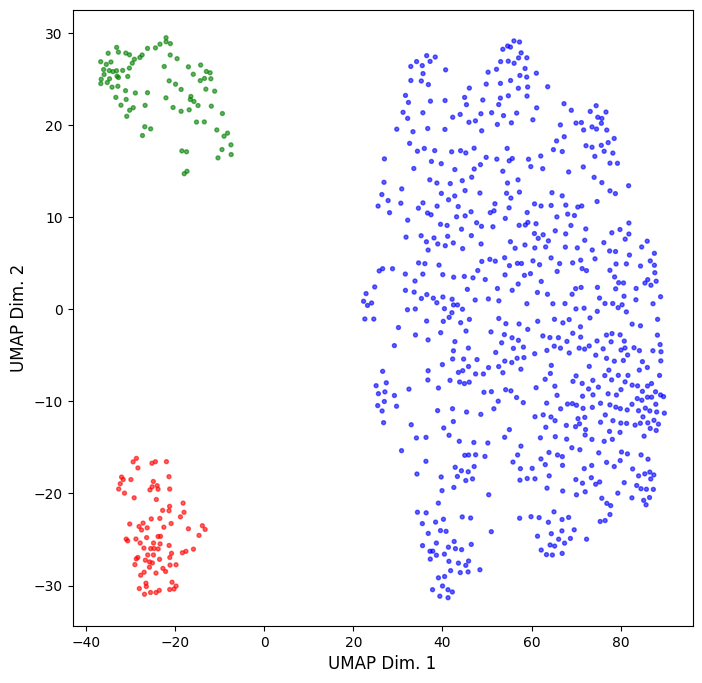

In [32]:
plt.figure(figsize=(8, 8))
color_map = {0: 'red', 1: 'blue', 2: 'green'}
colors = [color_map[label] for label in y]
scatter = plt.scatter(embedding[:, 0], embedding[:, 1], c=colors,  s=8, alpha=0.6)
plt.xlabel("UMAP Dim. 1", fontsize=12)
plt.ylabel("UMAP Dim. 2", fontsize=12)
plt.savefig("../output/Chess.com/Chess_CON_UMAP.eps", format='eps')
plt.show()

#### Feature Importance

In [33]:
model = models['RandomForestClassifier']
feature_names = matrix_df_combined.iloc[:, 1:].columns
feature_importance = pd.DataFrame({'Feature': feature_names,  'Importance': model.feature_importances_}).sort_values(by='Importance', ascending=False)
feature_importance['Feature_Group'] = feature_importance['Feature'].str.split('_').str[0]
aggregated_importance = feature_importance.groupby('Feature_Group', as_index=False)['Importance'].sum()
aggregated_importance = aggregated_importance.sort_values(by='Importance', ascending=False)
display(aggregated_importance)

,Feature_Group,Importance
4,pagerank,0.283978
2,indegree,0.198423
1,closeness,0.188061
3,outdegree,0.168201
0,CON,0.161337


In [34]:
max_importance = feature_importance.groupby('Feature_Group', as_index=False)['Importance'].max()
max_importance = max_importance.sort_values(by='Importance', ascending=False)
display(max_importance)

,Feature_Group,Importance
2,indegree,0.019821
4,pagerank,0.016397
1,closeness,0.012377
3,outdegree,0.011563
0,CON,0.007449


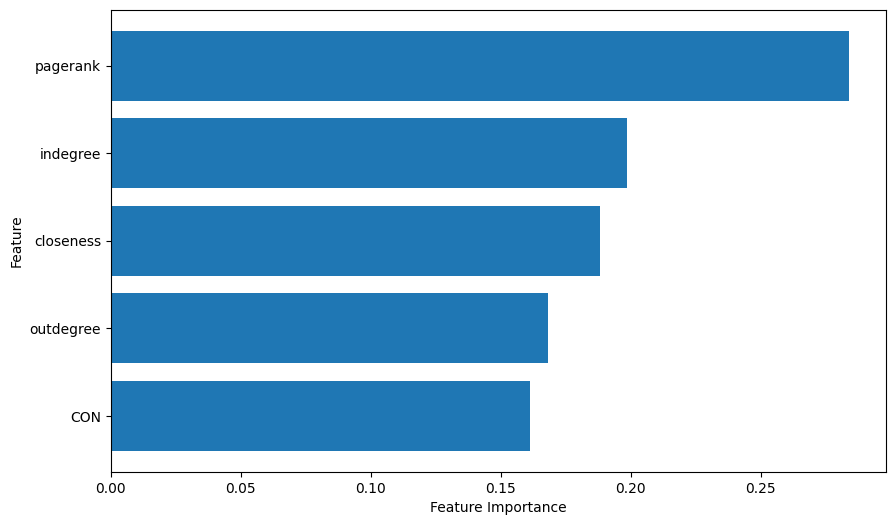

In [35]:
plt.figure(figsize=(10, 6))
plt.barh(aggregated_importance['Feature_Group'], aggregated_importance['Importance'])
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.gca().invert_yaxis() 
plt.savefig("../output/Chess.com/Chess.com_fi_bar_plot.svg", format='svg')
plt.show()

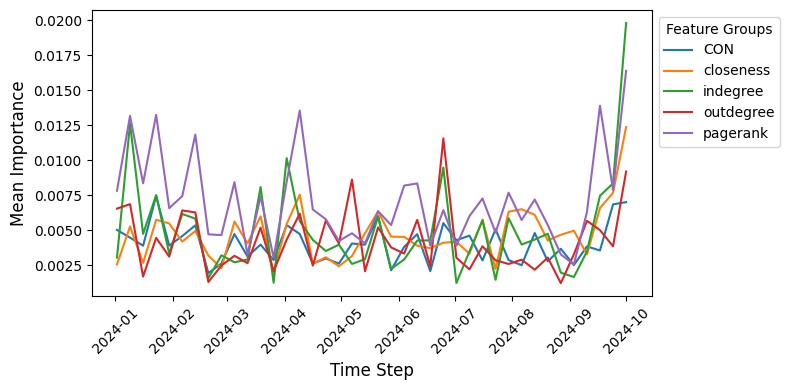

In [36]:
import matplotlib.pyplot as plt
import pandas as pd

feature_importance['Feature_Group'] = feature_importance['Feature'].str.split('_').str[0]
feature_importance['Time_Step'] = feature_importance['Feature'].str.split('_').str[1]

feature_importance['Time_Step'] = pd.to_datetime(feature_importance['Time_Step'], format='%d%B%Y', errors='coerce')
feature_importance = feature_importance.dropna(subset=['Time_Step'])
group_time_mean_importance = feature_importance.groupby(['Feature_Group', 'Time_Step'], as_index=False)['Importance'].mean()

time_step_importance = group_time_mean_importance.pivot(
    index='Time_Step', columns='Feature_Group', values='Importance'
)

time_step_importance = time_step_importance.sort_index()

plt.figure(figsize=(8, 4))
for group in time_step_importance.columns:
    plt.plot(time_step_importance.index, time_step_importance[group], label=group)

plt.xlabel('Time Step', fontsize=12)
plt.ylabel('Mean Importance', fontsize=12)
plt.xticks(rotation=45)  
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title="Feature Groups")
plt.grid(False)
plt.tight_layout()
plt.savefig("../output/Chess.com/Chess.com_fi_time_plot.svg", format='svg')
plt.show()